# Data Set

In [57]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms as tt
import pandas as pd
import torch
import matplotlib.pyplot as plt
import torchvision
import numpy as np


In [58]:
IMAGE_SIZE = 256
BATCH_SIZE = 1

class VisualWSDDataset(Dataset):
    def __init__(self, mode="train_all", image_transform=None, text_transform=None, tokenizer=None, test_lang='en', translate=False):
        self.image_transform = image_transform
        self.text_transform = text_transform
        self.tokenizer = tokenizer
        self.mode = mode
        self.translate = translate

        self.base_path = './data/semeval-2023-task-1-V-WSD-train-v1/train_v1/'
        self.data_txt_path = self.base_path + 'train.data.v1.txt'
        self.gold_txt_path = self.base_path + 'train.gold.v1.txt'
        self.image_path = self.base_path + '/train_images_v1/'

        if mode == "train_all":
            self.base_path_coco = './data/coco/'
            self.gold_txt_path_coco = self.base_path_coco + 'train.gold.v1.txt'
            self.image_path_coco = self.base_path_coco + '/train_images_v1/'

        elif mode == "test":
            self.base_path = './data/'
            self.data_txt_path = self.base_path + test_lang + '.test.data.v1.1.txt'
            self.gold_txt_path = self.base_path + test_lang + '.test.gold.v1.1.txt'
            self.image_path = self.base_path + '/test_images_resized/'
            self.text_translation = './it_en.txt'

            if test_lang == 'fa':
                self.data_txt_path = self.base_path + test_lang + '.test.data.txt'
                self.gold_txt_path = self.base_path + test_lang + '.test.gold.txt'
                self.text_translation = './fa_en.txt'

            # open translation file
            trans_file = open(self.text_translation, 'r')
            self.gold_translation = [line.rstrip() for line in trans_file]

        elif mode == "val":
            self.base_path = './data/semeval-2023-task-1-V-WSD-train-v1/trial_v1/'
            self.data_txt_path = self.base_path + 'trial.data.v1.txt'
            self.gold_txt_path = self.base_path + 'trial.gold.v1.txt'
            self.image_path = self.base_path + '/trial_images_v1/'
        

        # load txts
        self.data_df = pd.read_csv(self.data_txt_path, delimiter = "\t", header=None)
        self.gold_df = pd.read_csv(self.gold_txt_path, delimiter = "\t", header=None)
        self.data_gold_df  = pd.concat([self.data_df.iloc[:, 0], self.data_df.iloc[:, 1], self.gold_df.iloc[:, 0]], axis=1, keys=['label', 'label_context', 'img_name'])
        
        if self.tokenizer != None:
            self.gold_token = self.tokenizer(self.data_gold_df['label_context'].to_list())

    def __len__(self):
        return len(self.data_gold_df)

    def __getitem__(self, idx):
        label = self.data_gold_df.iloc[idx]['label']
        label_context = self.data_gold_df.iloc[idx]['label_context']
        correct_image_name = self.data_gold_df.iloc[idx]['img_name']
        images_series = self.data_df.iloc[idx][2:]
        correct_image_idx = images_series[images_series == correct_image_name].index[0]-2
        images = []

        # swap label context with translated one
        if self.translate:
            label_context = self.gold_translation[idx]

        if self.mode == "test":
            for item in images_series:
                    images.append(Image.open(self.image_path + item).convert('RGB'))
            correct_image = images[correct_image_idx]
        else:
            correct_image = Image.open(self.image_path + images_series[correct_image_idx+2]).convert('RGB')

        if self.image_transform:
            correct_image = self.image_transform(correct_image)
            for idx in range(len(images)):
                images[idx] = self.image_transform(images[idx])

        if self.text_transform:
            label = self.text_transform(label)
            label_context = self.text_transform(label_context)

        if self.tokenizer != None:
            # labels are the correct images
            # input_ids and attention_mask are tokenized text
            item = {key: torch.tensor(val[idx]) for key, val in self.gold_token.items()}
            item['images'] = torch.tensor(correct_image).detach()
            return item

        return {'label': label, 'label_context': label_context, 'correct_idx': correct_image_idx, 'correct_img': correct_image, 'imgs': images}

In [59]:
scale = tt.Resize((IMAGE_SIZE, IMAGE_SIZE))
tensor = tt.ToTensor()
image_composed = tt.transforms.Compose([scale, tensor])

In [60]:
train_set = VisualWSDDataset(mode="train", image_transform=image_composed)
test_set = VisualWSDDataset(mode="test", image_transform=image_composed, test_lang='en')
test_set_fa = VisualWSDDataset(mode="test", image_transform=image_composed, test_lang='fa', translate=True)
test_set_it = VisualWSDDataset(mode="test", image_transform=image_composed, test_lang='it', translate=True)
trial_set = VisualWSDDataset(mode="val", image_transform=image_composed)

In [61]:
print(len(train_set))
print(len(test_set))
print(len(trial_set))


12869
463
16


In [62]:
def imshow(img):
    img = img #/ 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [63]:
def visualize_set(data_set):
    for i, sample in enumerate(data_set):
        print(i, sample['label'], sample['label_context'], len(sample['imgs']), sample['correct_idx'])
        
        if len(sample['imgs']) > 0:
            imshow(torchvision.utils.make_grid(sample['imgs']))
        imshow(sample['correct_img'])
        
        if i == 3:
            break

0 moorhen moorhen swamphen 0 5


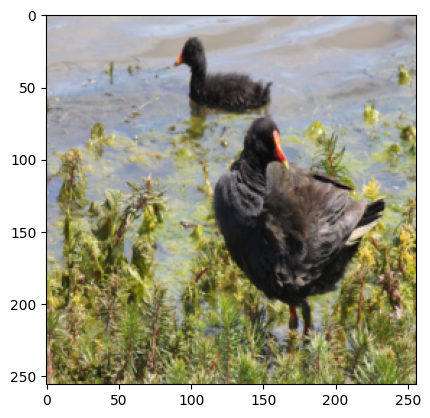

1 serinus serinus genus 0 5


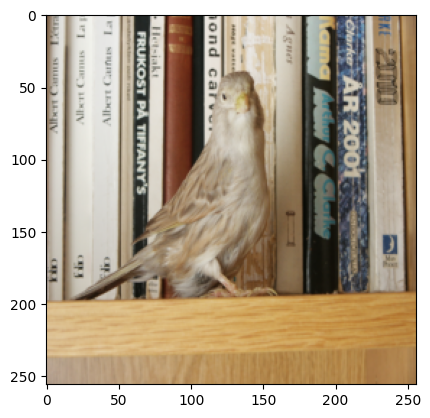

2 pegmatite pegmatite gneous 0 9


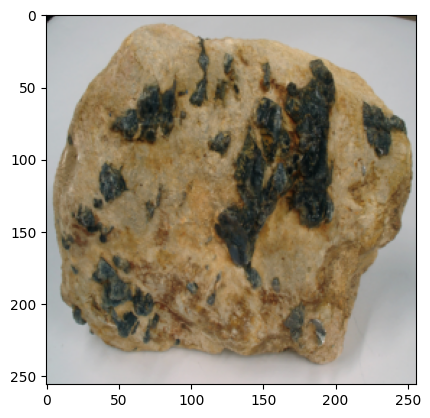

3 bangalores bangalores torpedo 0 4


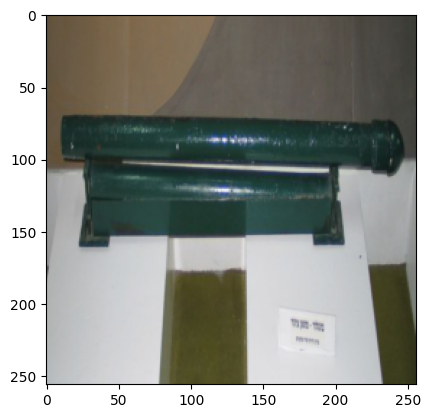

In [64]:
visualize_set(train_set)

0 goal football goal 10 8


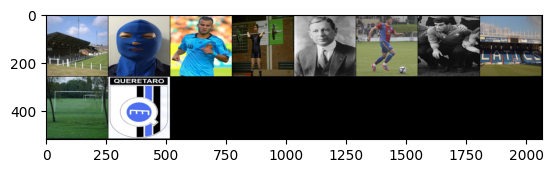

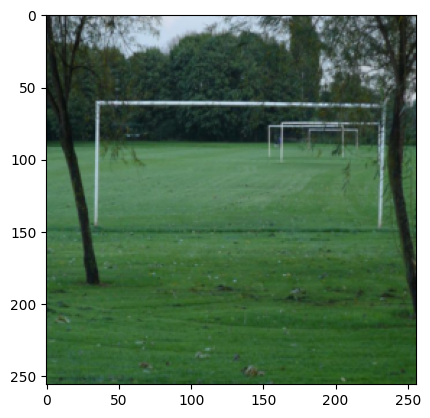

1 mustard mustard seed 10 0


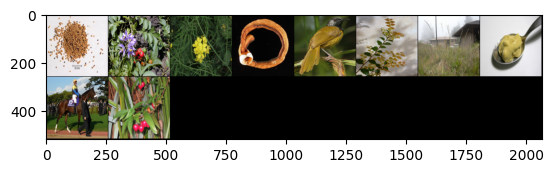

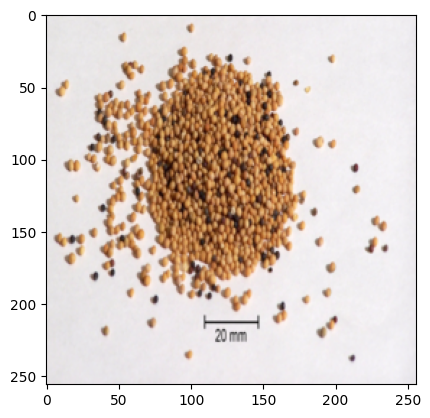

2 seat eating seat 10 5


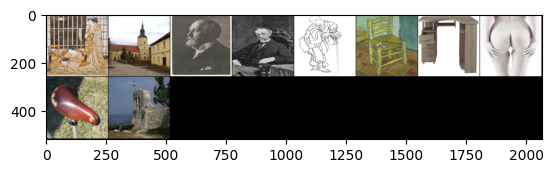

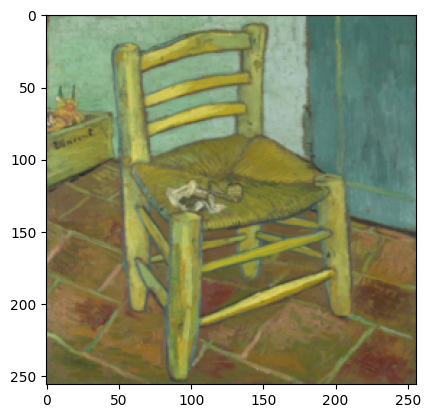

3 navigate navigate the web 10 6


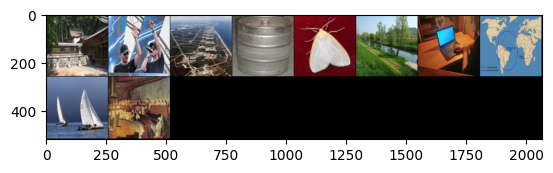

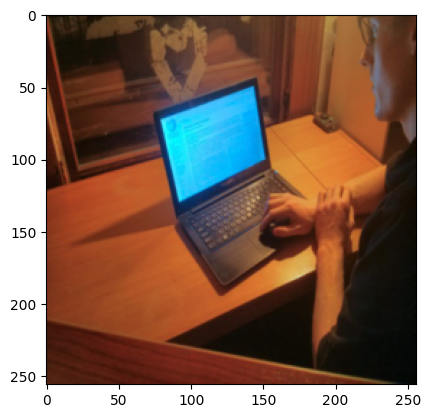

In [65]:
visualize_set(test_set)

0 andromeda andromeda tree 0 5


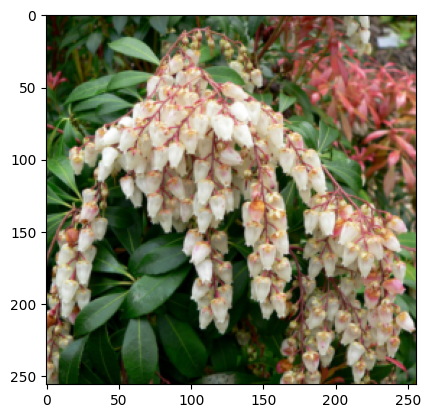

1 angora angora city 0 3


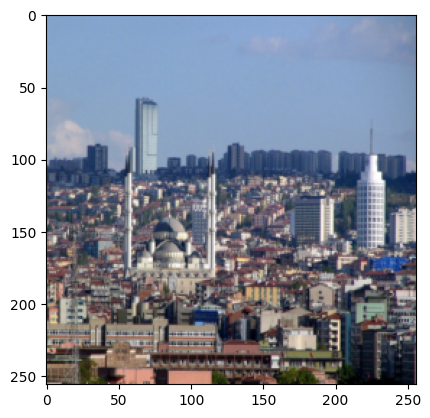

2 anteater marsupial anteater 0 2


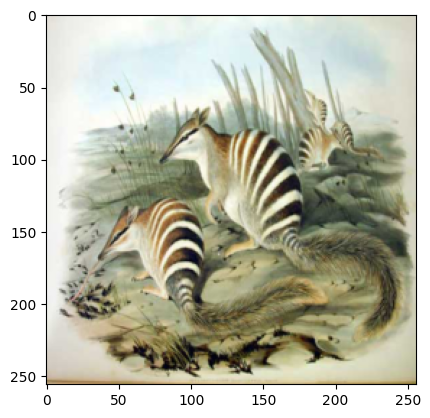

3 bank bank erosion 0 1


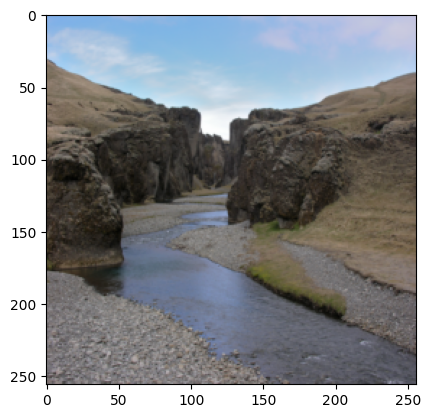

In [66]:
visualize_set(trial_set)

0 gomma eraser for stain removal 10 2


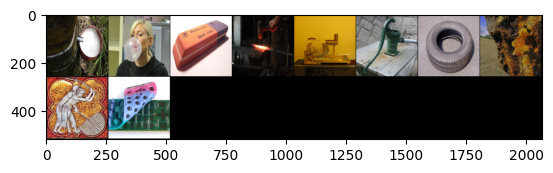

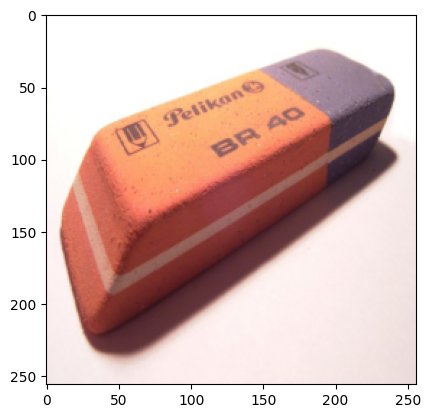

1 asino donkey card game 10 0


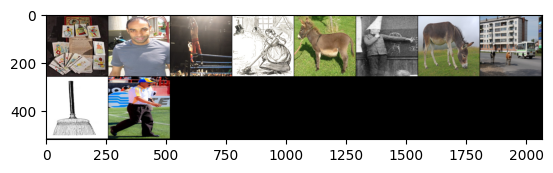

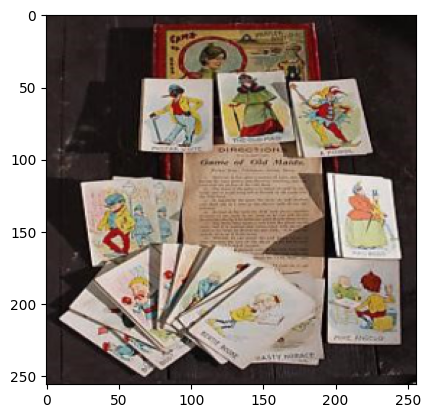

2 colonna mission column 10 6


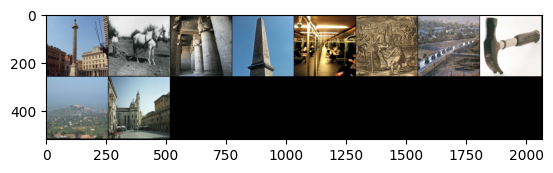

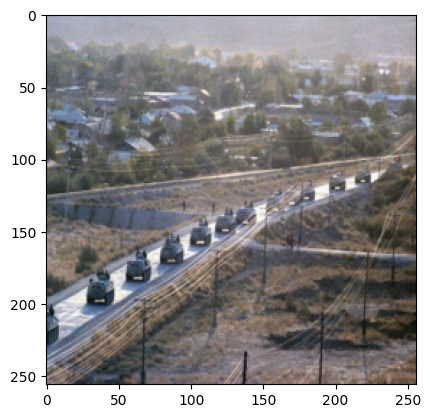

3 box playpen for infants 10 5


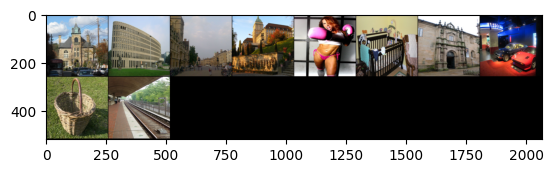

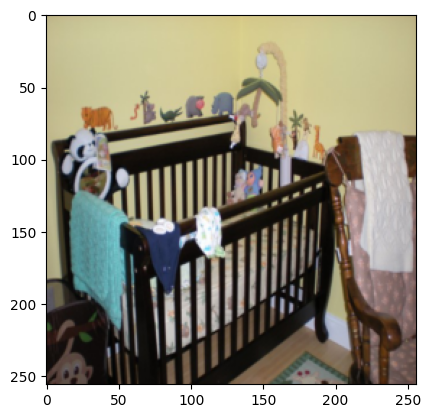

In [67]:
visualize_set(test_set_it)

0 برنج‎ brass 10 3


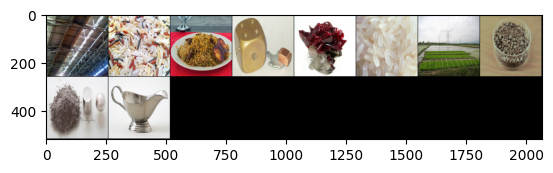

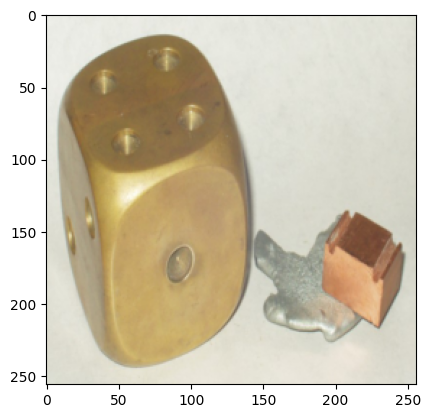

1 ملخ Wind grasshopper 10 3


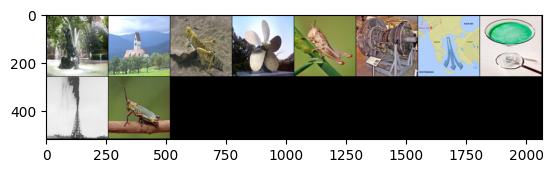

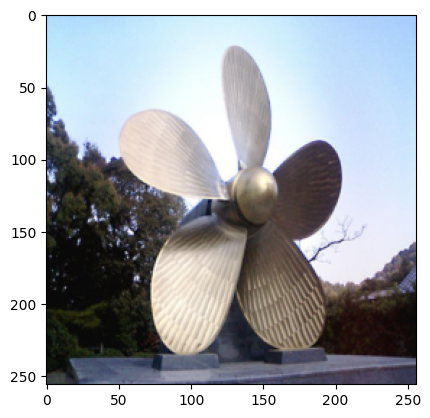

2 شام Sham land 10 8


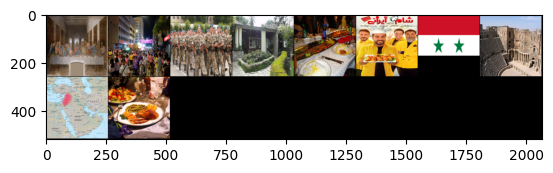

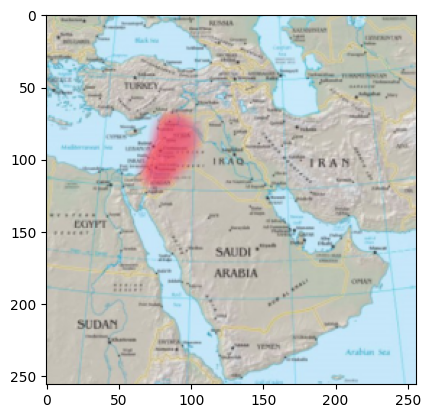

3 عدسی light lens 10 8


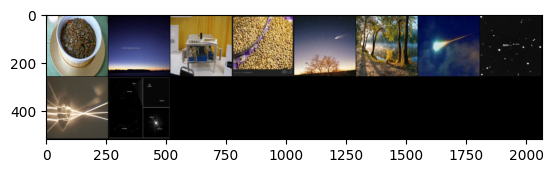

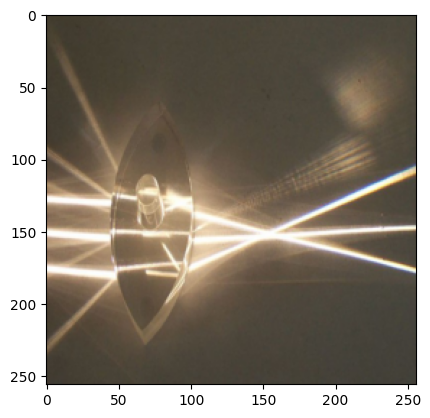

In [68]:
visualize_set(test_set_fa)

In [69]:
from transformers import DistilBertTokenizerFast

def tokens(texts):
    tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
    return tokenizer(texts, truncation=True, padding=True)

In [70]:
trial_set_token = VisualWSDDataset(mode="val", image_transform=image_composed, tokenizer=tokens)
train_set_token = VisualWSDDataset(mode="train", image_transform=image_composed, tokenizer=tokens)

In [71]:
print(len(trial_set_token))
print(len(train_set_token))

16
12869


In [72]:
trial_set_token[0]

/tmp/ipykernel_567275/3050695652.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['images'] = torch.tensor(correct_image).detach()


{'input_ids': tensor([  101,  1998, 21716, 11960,  3392,   102,     0,     0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 0, 0]),
 'images': tensor([[[0.0510, 0.0118, 0.0510,  ..., 0.3098, 0.3059, 0.3216],
          [0.1098, 0.0431, 0.0549,  ..., 0.2510, 0.2471, 0.2667],
          [0.0667, 0.0510, 0.0784,  ..., 0.1490, 0.1294, 0.1804],
          ...,
          [0.6471, 0.5412, 0.4784,  ..., 0.1294, 0.1333, 0.1882],
          [0.5922, 0.4941, 0.4706,  ..., 0.1569, 0.1412, 0.2275],
          [0.5765, 0.5059, 0.4941,  ..., 0.1608, 0.1725, 0.3255]],
 
         [[0.1059, 0.0863, 0.0706,  ..., 0.3216, 0.3294, 0.3451],
          [0.1333, 0.0980, 0.0588,  ..., 0.2549, 0.2627, 0.2941],
          [0.1333, 0.0980, 0.0431,  ..., 0.1451, 0.1490, 0.2078],
          ...,
          [0.6627, 0.5529, 0.4667,  ..., 0.2706, 0.3059, 0.3020],
          [0.6078, 0.4980, 0.4706,  ..., 0.3137, 0.2863, 0.2510],
          [0.5843, 0.5059, 0.4980,  ..., 0.3137, 0.2627, 0.2235]],
 
         [[0.0235, 0.0039, 0.

In [73]:
test_set_fa = VisualWSDDataset(mode="test", image_transform=image_composed, test_lang='fa')
test_set_it = VisualWSDDataset(mode="test", image_transform=image_composed, test_lang='it')

In [74]:
len(test_set_fa)

200

In [75]:
texts = []
for i, sample in enumerate(test_set_fa):
        print(sample['label'])
        texts.append(sample['label_context'])


برنج‎
ملخ
شام
عدسی
توپ
پیوند
دسته
چنگ
سرطان
عاج
گیلاس
جدول
رکاب
کبک
زبان
پرچم
بند
سرباز
عرق
سبزی
فرمان
شیر
عرق
اختر
پگاسوس
عود
عدسی
میل
اسکی
پرک
مين
لولو
اختناق
جوش
لوت
ميمون
سینا
گل
توان
لنت
کلید
زبان
تار
کارتن
سیب
گیلاس
کره
باد
اسفنج
فیل
کره
پولک
افغانی
مريم
ارتفاع
عرق
کرم
موس
شکست
ملک
کره
کیش
جرم
موس
آکسفورد
كبك
گوشت
برنج‎
جدول
تور
پاپ
ضرب
انقلاب
شكارچي
دیافراگم
کشتی
جفت
مریم
ده
دام
مالت
بید
اسب
قطر
دیافراگم
كيوي
زبان
مهر
تير
منشور
اسفنج
کنگره
زمین
بند
شاه
مهره
دوش
اسكی
کپسول
شاه
ماه
لگد
قرص
بشر
دبی
ماده
کیش
شیر
سنت
کشتی
روی‎
ریش
شیر
عالم
کارتن
کروم
حلال
کورس
روی‎
دو
ترازو
دکمه
کره
فانوس
اپرا
پارک
مالت
نی
جوش
گرده
شیر
ستاره
دایره
باز
دلتا
چک
باز
حمله
باله
مهره
فضا
تلمبه
زنگ
لب
میدان
جرم
عرق
سنت
حلال
پیچ
تولد
شیشه
پست
پیوند
لنگ
شور
خال
ده
تخم
قرص
چین
قوس
مارس
مدرس
مدل
سنج
عاج
سلول
کشتی‎
گونيا
ميدان
شکست
عود
هرم
در
زر
لوت
رخ
روی
یخچال
اصلاح
پاپ
مربع
شاهی
رینگ
دوش
کشتی
کبک
شیر
رسم
شير
كرم
لنز
شاهی
تیر
شير
کلنگ
صور
پايتون
پیوند


In [76]:
texts_50 = [texts[i:i+50] for i in range(0, len(texts), 50)]

In [77]:
for i in texts_50[3]:
    print(i)

تولد یک تازه وارد
شیشه مخدر
پست و دون
پیوند اتمی
لنگ تلوتلو خوردن
آفت شور
خال گوشتی
مبنای ده
تخم ریحان
قرص نان
چین پارچه
قوس تخلیه
مارس میلادی
مدرس هندوستان
مدل عکاسی
ساز سنج
عاج دندان
سلول انفرادی
کشتی‎ شناور
گونيا راه شیری
ميدان فیزیکی
شکست نور
بوی عود
هرم مصر
كوبه در
سیم و زر
لوت دشت
قلعه رخ
روی چهره
ذوب یخچال
اصلاح مو
موسیقی پاپ
مربع عدد
تره شاهی
رینگ بوکس
دوش شانه
کشتی فرنگی
کبک کانادا
شیر پستان
رسم تجسمی
شير کم چرب
كرم خاکی
لنز کنون
شاهی تومان
تیر و پرتابه
شير جنگل
انقراض کلنگ
شكارچي صور
پايتون سمی
پیوند عضو


In [78]:
len(test_set_it)

305

In [79]:
texts = []
for i, sample in enumerate(test_set_it):
        print(sample['label'])
        texts.append(sample['label_context'])

gomma
asino
colonna
box
bolla
banco
durone
alfiere
chiocciola
aquila
esecuzione
medusa
cassa
bacino
barba
mimosa
ariete
iceberg
centauro
ariete
carta
fiocco
mosca
argine
albero
gru
cipolla
iride
angelo
apertura
banco
limetta
ferro
bomba
canna
asta
gomma
caramella
leone
bolla
penna
catena
riccio
cartella
cacao
cocco
baco
piumino
cassa
babele
camaleonte
batteria
jfk
calcagno
cuffia
orbita
rosa
corona
lama
muro
rampicante
presa
coda
cappuccino
asta
caffè
cipolla
iceberg
riccio
lino
retina
crema
lima
obiettivo
ariete
retina
cotta
galletto
impermeabile
ciccia
rosa
lampo
fusto
porta
giacinto
cappa
mimo
aquila
carro
rocco
cocco
coca
piano
erba
ago
riso
elica
ittero
dado
gru
ambrosia
disco
olio
giostra
chiave
crema
minerale
mazza
campanella
moto
limetta
lampo
manhattan
martello
passerina
corona
espresso
cascata
cucù
cassa
fiocco
porta
cimice
mazza
film
brocca
fede
nido
filo
catena
bilancia
campagna
ariete
pizzo
coriandolo
mazza
rana
porto
cavallo
coccio
lira
frattura
menta
dracaena
leone
calat

In [80]:
texts_50 = [texts[i:i+80] for i in range(0, len(texts), 80)]


In [81]:
for i in texts_50[3]:
    print(i)

procione animale
grifone volatile
gola del terreno
pollice misurazione
bagno nuoto
golf maglione
conga ballo
carambola arbusto
ceppo di prigionia
pianta pigliamosche
campagna politica
calcio impugnatura
dado per viti
racchetta da tennis
nuotare a farfalla
kiwi uccello
porro ortaggio
batteria per l'elettricità
cappa aspiratore
barbone bestia
coperto servizio
cacao seme
bacchetta per mangiare
dorso piscina
baco informatico
stile a delfino
mezzo anfibio
rondella per bulloni
deposito posa
barca scialuppa
ghiacciolo commestibile
balestra del medioevo
barriera cancello
rete marina
masticare la gomma
cielo del soffitto
cuffia per audio
essere anfibio
canale di navigazione
berta volatile
cintola per stringere
asino erbivoro
gola umana
banco panchina
colonna portante
caramella gommosa
atropo insetto
boa sciarpa
capsula blister
bastoni per uno sport
adesivo figurina
riso di gioia
eremita paguro
boa rettile
alfiere rappresentante
giacinto foglie
fusto addome
penna cibo
olio bevibile
capsula press